In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import seaborn as sns
%matplotlib inline

In [37]:
# import calendar.csv
calendar = pd.read_csv('./Data/calendar.csv')
print(calendar.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1393570 entries, 0 to 1393569
Data columns (total 4 columns):
listing_id    1393570 non-null int64
date          1393570 non-null object
available     1393570 non-null object
price         934542 non-null object
dtypes: int64(1), object(3)
memory usage: 42.5+ MB
None


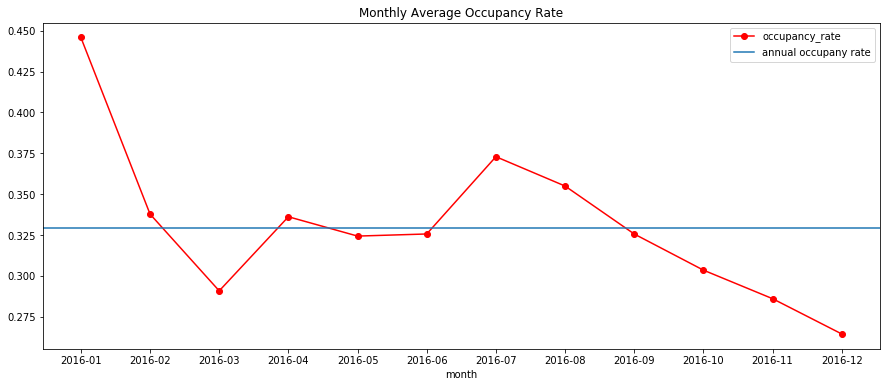

In [3]:
# Check the monthly occupancy rate - total bookings/total listings by month

calendar['month'] = calendar['date'].apply(lambda dt: dt[:7])
monthly_occupancy_rate = calendar.groupby('month')['price'].apply(lambda p: p.isnull().sum()/len(p)).rename('occupancy_rate')

# Check the monthly listing counts.
monthly_listings = calendar.groupby('month').listing_id.count().rename('total_listings')
monthly_unique_listings = calendar.groupby('month').listing_id.nunique().rename('unique_listings')
monthly_occupancy_rate = pd.concat([monthly_listings,monthly_unique_listings,monthly_occupancy_rate], axis = 1).reset_index().sort_values('month')

# Exclude 2017-01 - there are two days' data available. 
monthly_occupancy_rate = monthly_occupancy_rate[monthly_occupancy_rate.month != '2017-01']

fig, ax1 = plt.subplots(figsize = (15,6))
ax1.plot(monthly_occupancy_rate.month, monthly_occupancy_rate.occupancy_rate,'-o', color = 'red')
ax1.axhline(calendar.price.isnull().mean(), label='annual occupany rate')
plt.legend(loc='upper right')
plt.xlabel('month')
plt.title('Monthly Average Occupancy Rate')
plt.legend(loc='upper right')


In [39]:
# import full description of listings.
listings = pd.read_csv('./Data/listings.csv')
print(listings.shape)

(3818, 92)


In [5]:
reviews_scores = listings.loc[:, listings.columns[listings.columns.str.startswith('review')]]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 8 columns):
review_scores_rating           3171 non-null float64
review_scores_accuracy         3160 non-null float64
review_scores_cleanliness      3165 non-null float64
review_scores_checkin          3160 non-null float64
review_scores_communication    3167 non-null float64
review_scores_location         3163 non-null float64
review_scores_value            3162 non-null float64
reviews_per_month              3191 non-null float64
dtypes: float64(8)
memory usage: 238.7 KB
None        review_scores_rating  review_scores_accuracy  \
count           3171.000000             3160.000000   
mean              94.539262                9.636392   
std                6.606083                0.698031   
min               20.000000                2.000000   
25%               93.000000                9.000000   
50%               96.000000               10.000000   
75%               99.000000           

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a28cee400>,
      dtype=object)

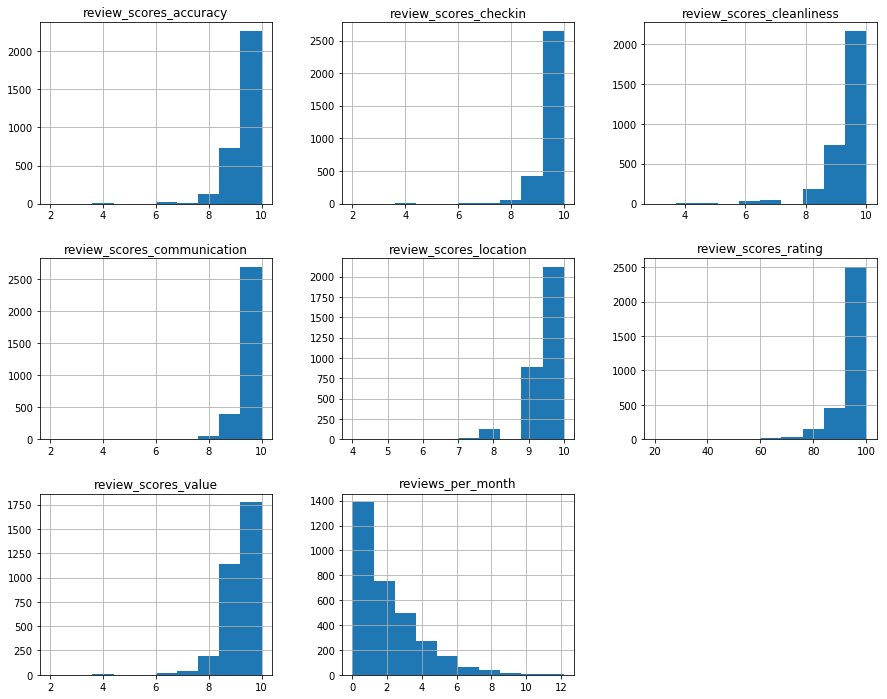

In [6]:
print(reviews_scores.info(), reviews_scores.describe())
reviews_scores.hist(bins = 10, figsize = (15,12))

In [7]:
reviews_scores.dropna()
# brackets of review scores
reviews_scores['reviews_rating_bracket'] = pd.cut(reviews_scores.review_scores_rating, bins = np.arange(0,110, 10))
reviews_scores_bracket = pd.concat([reviews_scores.groupby('reviews_rating_bracket').size().rename('cnt'), \
        reviews_scores.groupby('reviews_rating_bracket')[['review_scores_accuracy', 'review_scores_cleanliness', 
                                                  'review_scores_checkin', 'review_scores_communication',
                                                     'review_scores_location', 'review_scores_value']].mean()], \
                                   axis = 1).reset_index()
reviews_scores_bracket['review_scores_decile'] = reviews_scores_bracket.reviews_rating_bracket.astype(str) + ", n = " + reviews_scores_bracket.cnt.astype(str)
reviews_scores_bracket = reviews_scores_bracket.drop(['cnt', 'reviews_rating_bracket', 'review_scores_value'], axis = 1).set_index('review_scores_decile')

Text(0.5, 1.0, 'Review Scores Breakdown Analysis')

<Figure size 432x288 with 0 Axes>

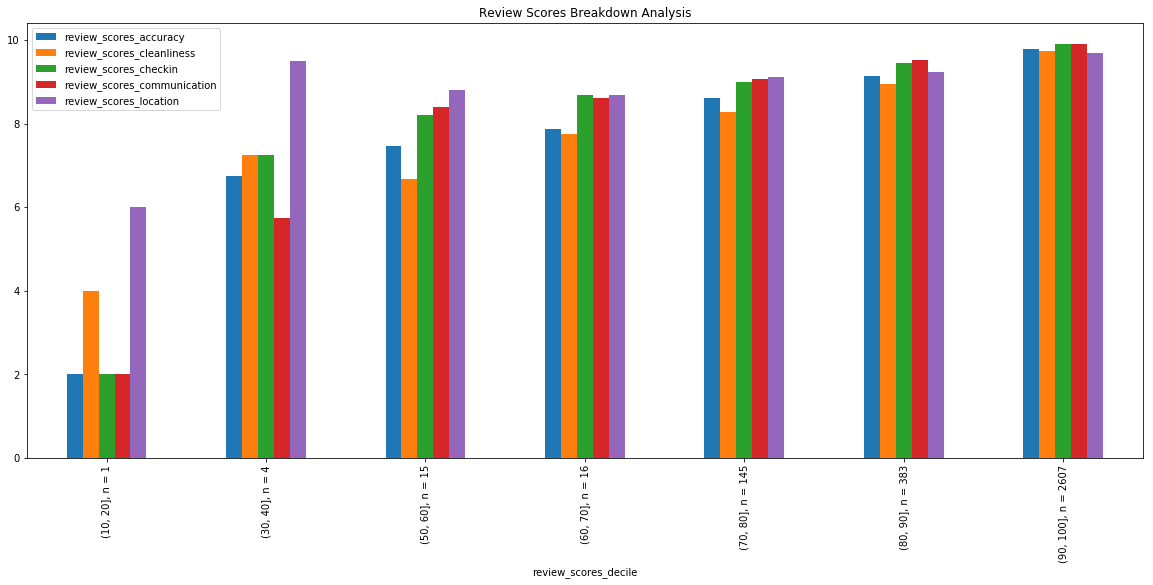

In [8]:
fig = plt.figure()
reviews_scores_bracket.dropna().plot.bar(figsize = (20, 8))
plt.title('Review Scores Breakdown Analysis')


Text(0, 0.5, 'review scores')

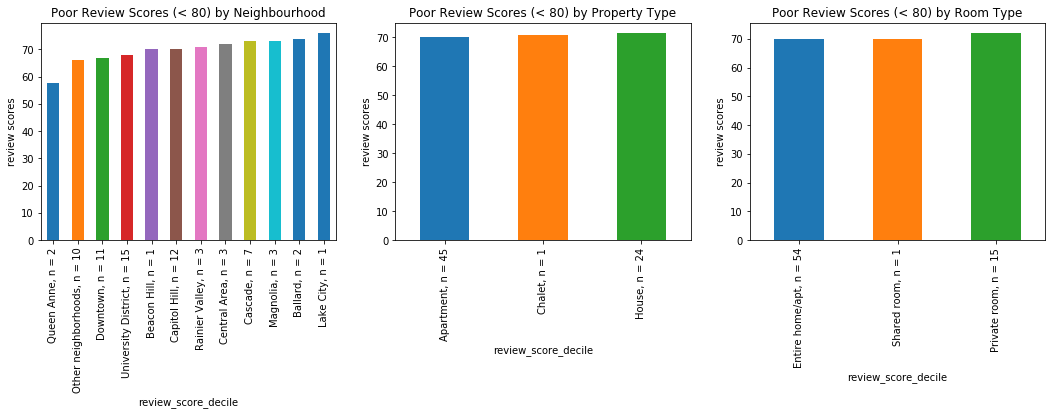

In [9]:
# breakdown of poor review scores(< 80)
res = {}
for col in ['neighbourhood_group_cleansed', 'room_type', 'property_type']:
    res[col] = listings[listings.review_scores_rating < 80][['id', 'neighbourhood_group_cleansed',\
            'zipcode', 'property_type', 'room_type', 'review_scores_rating']].dropna().\
            groupby(col)['review_scores_rating'].agg(['count', 'median']).sort_values('median').reset_index()
    res[col]['review_score_decile'] = res[col][col].astype(str) + ', n = ' + res[col]['count'].astype(str)
    res[col] = res[col].drop(['count', col], axis = 1).set_index('review_score_decile')
    

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (18, 4))
res['neighbourhood_group_cleansed']['median'].plot.bar(ax = ax1)
ax1.set_title('Poor Review Scores (< 80) by Neighbourhood')
ax1.set_ylabel('review scores')

res['property_type']['median'].plot.bar(ax = ax2)
ax2.set_title('Poor Review Scores (< 80) by Property Type')
ax2.set_ylabel('review scores')

res['room_type']['median'].plot.bar(ax = ax3)
ax3.set_title('Poor Review Scores (< 80) by Room Type')
ax3.set_ylabel('review scores')


In [61]:
# supply and demand of Airbnb homes
df = pd.concat([calendar.groupby('listing_id').price.apply(lambda p: p.isna().sum()).reset_index().\
    rename(columns = {'listing_id':'id', 'price':'total_bookings'}), calendar.groupby('listing_id').price.\
           apply(lambda p: len(p)).reset_index().rename(columns = {'price':'total_listings'})], axis = 1).merge(listings, on = 'id')

res = {}
for col in ['neighbourhood_group_cleansed', 'room_type', 'property_type']:
    res[col] = df.groupby(col)['total_bookings','total_listings'].sum().sort_values('total_bookings', ascending = False)
    res[col]['occupancy_rate'] = res[col]['total_bookings'] / res[col]['total_bookings'] 

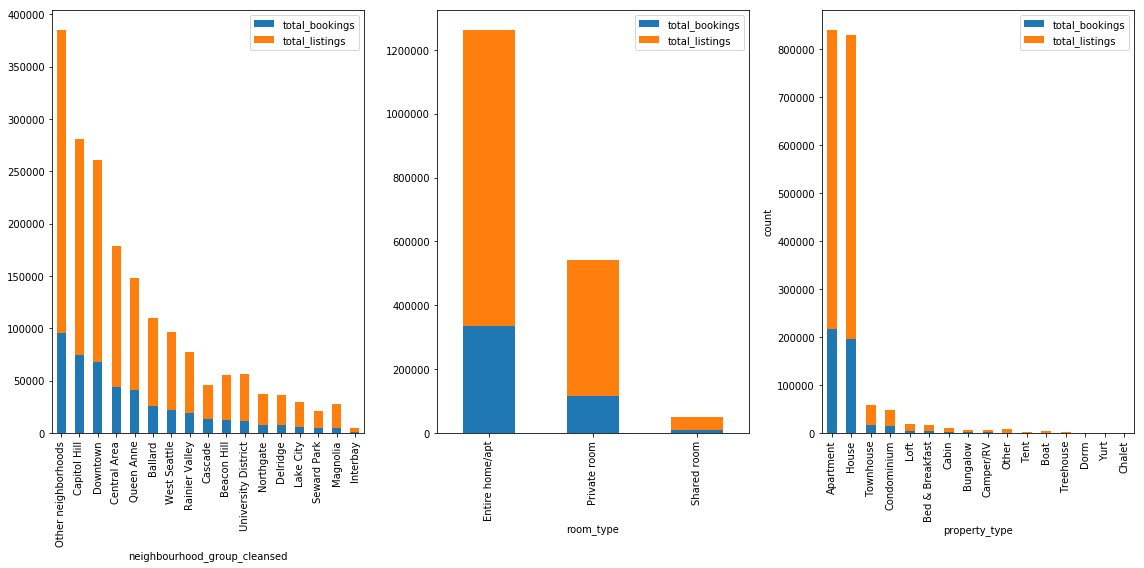

In [60]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (16, 8))

res['neighbourhood_group_cleansed'].plot(kind = 'bar', stacked = True, ax = ax1)
plt.ylabel('count')

res['room_type'].plot(kind = 'bar', stacked = True, ax = ax2)
plt.ylabel('count')

res['property_type'].plot(kind = 'bar', stacked = True, ax = ax3)
plt.ylabel('count')

plt.tight_layout()

In [14]:

listings['price'] = listings.price.apply(lambda x: x.strip('$').replace(',', '') if type(x) == str else x).astype(float)
listings['cleaning_fee'] = listings.cleaning_fee.apply(lambda x: x.strip('$').replace(',', '') if type(x) == str else x).astype(float)
listings['extra_people'] = listings.extra_people.apply(lambda x: x.strip('$').replace(',', '') if type(x) == str else x).astype(float)
listings['host_response_rate'] = listings.host_response_rate.apply(lambda x: float(x.strip('%').replace(',', '')) / 100 if type(x) == str else x).astype(float)


In [15]:
# Feature Selection - Predict Price
df_num_features = listings[['price','host_response_rate','accommodates','bathrooms', 'bedrooms','beds',\
 'cleaning_fee','guests_included', 'extra_people', 'number_of_reviews','review_scores_rating',\
 'review_scores_accuracy','review_scores_cleanliness', 'review_scores_checkin','review_scores_communication',\
 'review_scores_location','review_scores_value', 'reviews_per_month']]

df_cat_features = listings[['price','host_response_time','host_is_superhost',\
 'host_identity_verified','neighbourhood_group_cleansed','zipcode','is_location_exact','property_type','room_type',\
 'instant_bookable','cancellation_policy']]

In [16]:
corr_dict = pd.Series()
for col in df_num_features.columns:
    corr_dict[col] = df_num_features[col].corr(df_num_features['price'])
df_num_features = df_num_features.drop(['review_scores_value', 'host_response_rate', 'review_scores_checkin', 'review_scores_communication',\
                     'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_rating', 'review_scores_location'],axis = 1)

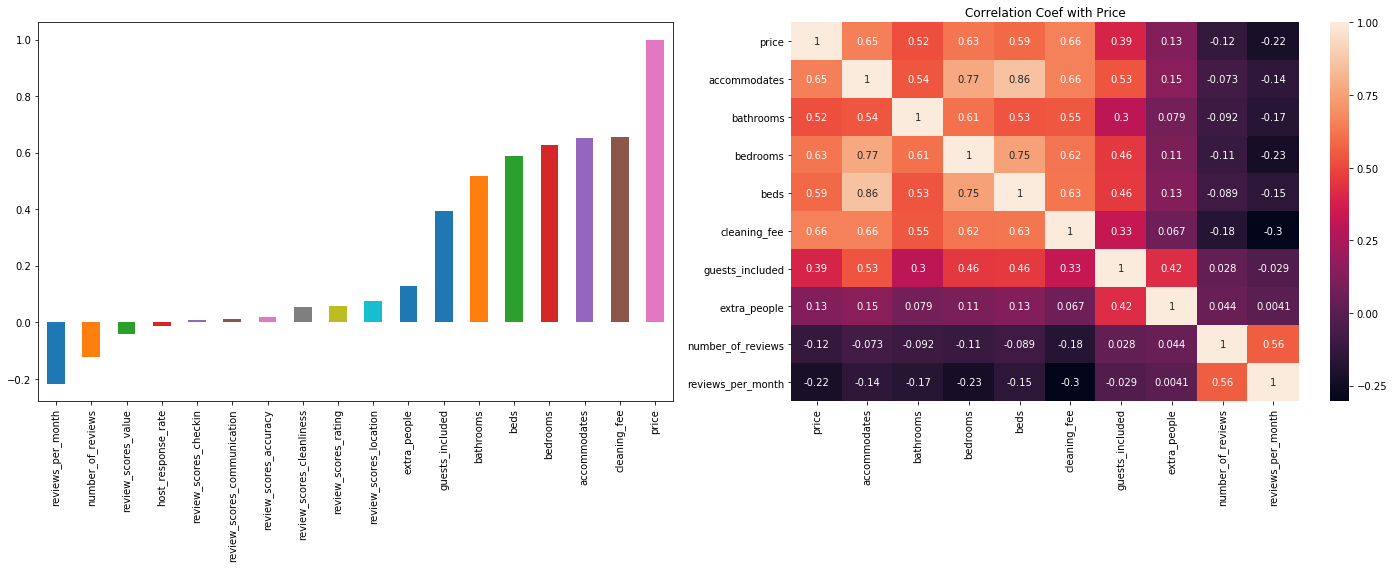

In [17]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize = (20, 8))
corr_dict.sort_values().plot.bar(ax = ax1)
ax2 = sns.heatmap(df_num_features.corr(), annot=True)
plt.title('Correlation Coef with Price')
plt.tight_layout()

In [18]:
res = {}
for col in df_cat_features.drop('price', axis = 1).columns:
    res[col] = df_cat_features.groupby(col)['price'].agg(['count', 'median', 'mean']).sort_values('median', ascending = False)


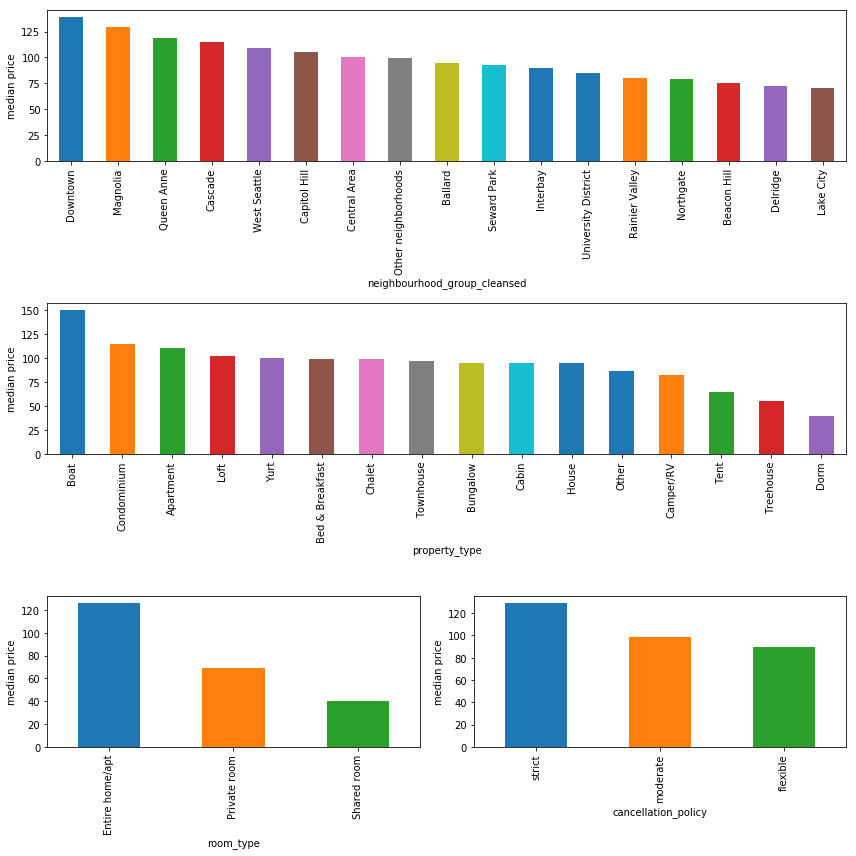

In [20]:
fig = plt.figure(figsize = (12, 12))
plt.subplot2grid((3,2),(0,0), colspan = 2) 
res['neighbourhood_group_cleansed']['median'].plot.bar()
plt.ylabel('median price')

plt.subplot2grid((3,2),(1,0), colspan = 2) 
res['property_type']['median'].plot.bar()
plt.ylabel('median price')

plt.subplot2grid((3,2),(2,0)) 
res['room_type']['median'].plot.bar()
plt.ylabel('median price')

plt.subplot2grid((3,2),(2,1)) 
res['cancellation_policy']['median'].plot.bar()
plt.ylabel('median price')

plt.tight_layout()